<a href="https://colab.research.google.com/github/kiyaoiki/FUTURE_ML_01/blob/main/ChurnPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- CELL 1 ---
# Install xgboost if not already updated
!pip install xgboost scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the Telco Churn Dataset directly from a stable GitHub URL
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("✅ Data Loaded Successfully!")
print(f"Dataset Shape: {df.shape}")
df.head()

✅ Data Loaded Successfully!
Dataset Shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# --- CELL 2 ---
# 1. Convert 'TotalCharges' to numeric, turning errors (empty strings) into NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# 2. Fill missing values (mostly new customers with 0 tenure) with 0
df['TotalCharges'].fillna(0, inplace=True)

# 3. Drop 'customerID' as it's not useful for prediction
df.drop(columns=['customerID'], inplace=True)

# 4. Encode the Target Variable ('Yes' -> 1, 'No' -> 0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

print("✅ Data Cleaned")
print("Missing Values Check:", df.isnull().sum().sum())

✅ Data Cleaned
Missing Values Check: 0


In [ ]:
# --- CELL 3 ---
from sklearn.model_selection import train_test_split

# 1. One-Hot Encoding for categorical features
df_processed = pd.get_dummies(df, drop_first=True)

# 2. Define X (Features) and y (Target)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# 3. Split into Train (80%) and Test (20%) sets
# 'stratify=y' ensures we have the same proportion of Churners in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Data Split Complete")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

✅ Data Split Complete
Training set size: (5634, 30)
Test set size: (1409, 30)


In [ ]:
# --- CELL 4 ---
from xgboost import XGBClassifier

# Initialize the model
model = XGBClassifier(
    n_estimators=100,      # Number of trees
    learning_rate=0.1,     # How fast the model learns
    max_depth=5,           # Depth of trees
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'  # Removes warning noise
)

# Train the model
model.fit(X_train, y_train)

print("✅ Model Trained Successfully")

✅ Model Trained Successfully


🎯 Model Accuracy: 79.56%
📈 ROC-AUC Score: 0.8412

🔍 Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409



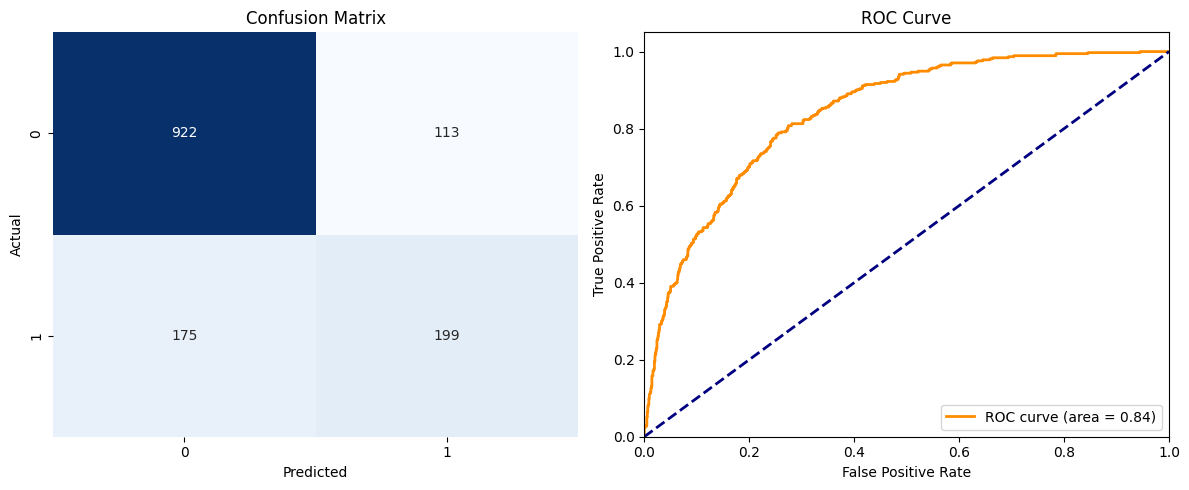

In [ ]:
# --- CELL 5 ---
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Probability of Churning

# Metrics
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(f"🎯 Model Accuracy: {acc:.2%}")
print(f"📈 ROC-AUC Score: {auc:.4f}")
print("\n🔍 Classification Report:\n", classification_report(y_test, y_pred))

# VISUALIZATIONS
plt.figure(figsize=(12, 5))

# Plot 1: Confusion Matrix
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Plot 2: ROC Curve
plt.subplot(1, 2, 2)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

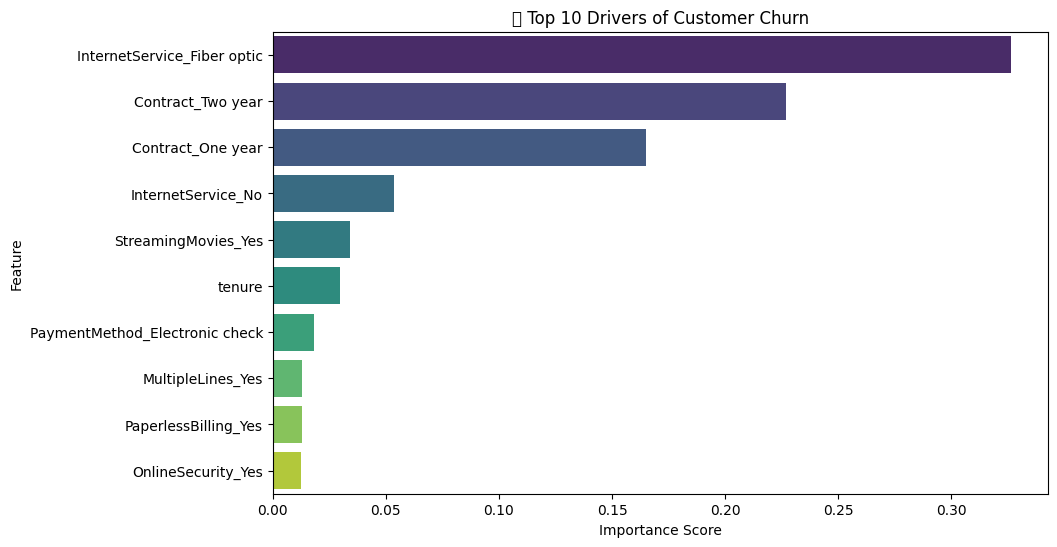

💡 Insight: The variables at the top are the strongest predictors of churn.


In [ ]:
# --- CELL 6 ---
# Get feature importance
importances = model.feature_importances_
feature_names = X.columns

# Create dataframe
feat_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
plt.title('🚀 Top 10 Drivers of Customer Churn')
plt.xlabel('Importance Score')
plt.show()

print("💡 Insight: The variables at the top are the strongest predictors of churn.")

In [ ]:
# --- CELL 7: Save and Download Model ---
import joblib
from google.colab import files

# 1. Save the trained model to a file in Colab
model_filename = 'telecom_churn_prediction_model.pkl'
joblib.dump(model, model_filename)

print(f"✅ Model saved as '{model_filename}'")

# 2. Trigger the download to your local computer
# (Note: If your browser blocks pop-ups, allow them for Colab)
try:
    files.download(model_filename)
    print("⬇️ Download started... check your downloads folder!")
except Exception as e:
    print("⚠️ Auto-download failed. You can manually download it from the file folder icon on the left.")


✅ Model saved as 'spotify_churn_prediction_model.pkl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

⬇️ Download started... check your downloads folder!


In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize Logistic Regression
lr_model = LogisticRegression(max_iter=1000)

# Train
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

# Evaluation
print("📌 Logistic Regression Results")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))


📌 Logistic Regression Results
Accuracy: 0.961
ROC-AUC: 0.9594932191291934
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       934
           1       0.79      0.56      0.65        66

    accuracy                           0.96      1000
   macro avg       0.88      0.77      0.82      1000
weighted avg       0.96      0.96      0.96      1000



In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

# Train
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("📌 Random Forest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


📌 Random Forest Results
Accuracy: 0.983
ROC-AUC: 0.9951495684900397
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       934
           1       0.92      0.82      0.86        66

    accuracy                           0.98      1000
   macro avg       0.95      0.91      0.93      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred)
    ],
    'ROC-AUC': [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob)
    ]
})

comparison_df


,Model,Accuracy,ROC-AUC
0,Logistic Regression,0.961,0.959493
1,Random Forest,0.983,0.995150
2,XGBoost,0.986,0.995247
